<h1>Introduction</h1>
<p>In these lab notes we will introduce you to Naïve Bayes and your task is to implement a relatively simple spam filter.  We will use a small data set to train and test the model (available on Blackboard). </p> 

<b>Note:</b>  Use Jupyter Notebook or Google Colab (NOT Jupyter Lab).
    
<p>The messages within the datasets have already been classified as ham (not spam), or spam. </p> 

<p>The implementation of a Naïve Bayes Spam Filter is relatively straight forward using scikit-learn, however, this library hides the implementation details (and many solutions are available on the Internet).  Therefore, this task does not permit the use of the scikit-learn library or similar libraries that perform similar tasks.  We hope that this will help with your understanding of the implementation details.</p> 
<p>Bayes Theorem can give us the probability that a message is spam S for a given event E</p>


$P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$


<p>Where:</p>
<p> $P\left(S\middle|\ E\right)$,  the probability that the message is spam given the event occurred.</p>
<p> $P\left(S\right)$, the prior probability that a message is spam.</p>
<p> $P\left(\lnot S\right)$, the prior probability that a message is not spam.  </>

Note:  $P\left(S\right)$ and $P\left(\lnot S\right)$ are prior values, or prior beliefs.  This value could be calculated using the number of spam and number of ham classifications in the data set.  You could also use arbitrary values, for example; you could assume that of all email messages sent, 80% of them are spam and 20% of them are not spam.  The success of the filter depends on the prior values.

<p>$P\left(E\middle|\ S\right)$, the probability that event E occurs in a spam emails.</p>

<p>$P\left(E|\lnot S\right)$, the probability that event E occurs in non-spam emails.</p>

<h3>Additional Libraries</h3>
<p>As you progress through the exercises you may need additional libraries that are not installed, for example when visualising the data you may need to import WordCloud.  If you use [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb) the necessary libraries will be available, which will save you having to pip install.  </p>
<h3>The Implementation</h3>
<p>We have tried to keep the implementation quite simple and therefore not accounted for things like filtering small often used words, nor does the implementation calculate probabilities of a word in the frequency list not appearing in spam.  We have also filtered things like telephone numbers, which could be used to identify spam.   The final exercise allows you to make recommendations how the model could be improved.    </p>


<h3>1.  Read the dataset into a dataframe and explore</h3>
<p>Start by importing pandas and read the dataset into a DataFrame named df.  Output the first 20 rows of the dataframe to get a general feel of how the data is structured.</p>
<p>You may encounter the error: UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 135-136: invalid continuation byte.  You don't need to edit the datafile.  I was able to successfully read in the datafile by changing the encoding to latin-1.</p>
<p>[1 Mark]</p>

In [1]:
import pandas as pd
import regex as re # To filter characters
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from math import log


df = pd.read_csv("spam.csv", encoding="latin-1")

<h3>2. Clean the data</h3>
<p>We are only interested in words, clean the data so that all punctuations are removed.  You should be left with a dataset that only contains alpha characters (including spaces).  You should also ensure all the words are lowercase.  Store the cleaned data into a DataFrame named clean.</p>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Category</th>
      <th>Message</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>ham</td>
      <td>go until jurong point crazy available only in ...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ham</td>
      <td>ok lar joking wif u oni</td>
    </tr>
    <tr>
      <th>2</th>
      <td>spam</td>
      <td>free entry in  a wkly comp to win fa cup final...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>ham</td>
      <td>u dun say so early hor u c already then say</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ham</td>
      <td>nah i dont think he goes to usf he lives aroun...</td>
    </tr>
  </tbody>
</table>

[2 Marks]

In [2]:
index_columns_to_drop = [2, 3, 4]
clean = df.drop(columns=df.columns[index_columns_to_drop])
clean = clean.rename(columns= {"v1": "Category", "v2": "Message"})
for i in range(len(clean["Message"])):
    clean["Message"][i] = clean["Message"][i].lower()
    clean["Message"][i] = " ".join(re.findall('[a-z]*', clean["Message"][i])) # Leaves letters
clean.head(20)

,Category,Message
0,ham,go until jurong point crazy available ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa ...
3,ham,u dun say so early hor u c already ...
4,ham,nah i don t think he goes to usf he ...
5,spam,freemsg hey there darling it s been w...
6,ham,even my brother is not like to speak w...
7,ham,as per your request melle melle oru m...
8,spam,winner as a valued network customer yo...
9,spam,had your mobile months or more u r ...


<h3>3. Split the Data</h3>
<p>Split the data into two random samples, one for training the model and the other for testing the model.  Create DataFrames named train_data and test_data.  The train_data DataFrame should contain 75% of the data and the test_data DataFrame the remaining 25%.<p>  

<p>[1 Mark]</p>

In [3]:
train_data = clean.sample(frac = 0.75, random_state = 2002)
test_data = clean.drop(index = train_data.index)

<h3>4. Create a Word Frequency DataFrame</h3>
<p>Create a new DataFrame named word_freq that contains each word with the number of times it appears in a spam and a ham message.  You should use the train_data not the test_data.</p>
<p>Below is an example of what the DataFrame would look like, <i>note</i> that your values may differ depending on how the data was split.</p>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Word</th>
      <th>#Spam</th>
      <th>#Ham</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>go</td>
      <td>27</td>
      <td>196</td>
    </tr>
    <tr>
      <td>1</td>
      <td>until</td>
      <td>4</td>
      <td>17</td>
    </tr>
    <tr>
      <td>2</td>
      <td>jurong</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>3</td>
      <td>point</td>
      <td>1</td>
      <td>9</td>
    </tr>
    <tr>
      <td>4</td>
      <td>crazy</td>
      <td>4</td>
      <td>8</td>
    </tr>
    <tr>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <td>7253</td>
      <td>salesman</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7254</td>
      <td>pity</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7255</td>
      <td>soany</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7256</td>
      <td>suggestions</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7257</td>
      <td>bitching</td>
      <td>1</td>
      <td>0</td>
    </tr>
  </tbody>
</table>
<p>[2 Marks]</p>

In [4]:
ham_data = train_data[train_data["Category"]=="ham"]
spam_data = train_data.drop(index=ham_data.index)

ham_series = pd.Series(' '.join([' '.join(set(ham_data["Message"][i].split())) for i in ham_data.index]).split()).value_counts().rename("#Ham")

spam_series = pd.Series(' '.join([' '.join(set(spam_data["Message"][i].split())) for i in spam_data.index]).split()).value_counts().rename("#Spam")

word_freq = pd.concat([ham_series, spam_series], axis=1).fillna(0).reset_index().rename(columns ={"index": "Word"})
word_freq[["#Ham", "#Spam"]] = word_freq[["#Ham", "#Spam"]].astype(int)
word_freq.sort_values("#Spam", ascending = False)


,Word,#Ham,#Spam
2,to,902,340
49,call,163,236
3,a,633,215
1,you,1003,177
25,your,266,166
...,...,...,...
1416,fetch,3,0
3295,predicte,1,0
1417,closer,3,0
3293,eventually,1,0


<h3>5. Visualise the Data</h3>
<p>Let's use a Word Cloud library to visualise the most common words contained in spam messages.</p>

[Example of a Word Cloud Image](https://drive.google.com/open?id=1lVRGHtMB1AMJf-JSi7MmcHbZB_BvBhGC)

<p>[3 Marks]</p>



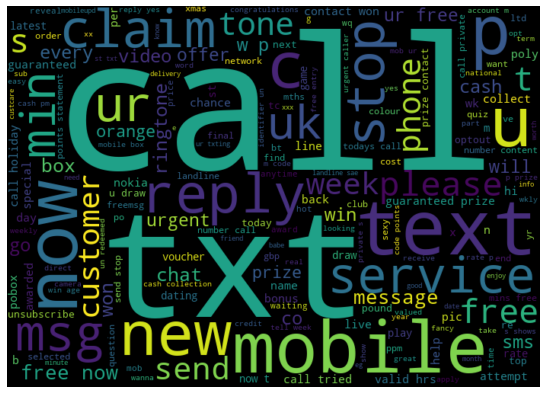

In [5]:
stopwords = set(STOPWORDS)
spam_wc = WordCloud(width=700, height=500, stopwords=stopwords)
spam_wc.generate(' '.join([' '.join(set(spam_data["Message"][i].split())) for i in spam_data.index]))

plt.figure(figsize=(10,7))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<h3>6.  Calculate $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$ </h3>
<p>Next create a new DataFrame named word_prob that gives the probability of each word being found in a spam and ham message.</p>
<p>To calculate the probability of a word being spam you divide the number of times the word was found in spam by the total number of spam messages, likewise to calculate the probability of each word being found in a ham message you divide the number of times the word was found in a ham message by the total number of ham messages.</p>
<p>If a word was not found in ham or spam it will cause problems later because the probability calculated will be zero. Therefore, use a pseudocount k and estimate the probability of seeing the word. This is known as smoothing and results in the following formula when k = 0.5, for example.</p>
<p>$P\left(E\middle| S\right)$ = (number of spams containing the word + k) / (total number of spam messages + 2 * k).</p>
<p>Likewise, for $P\left(E|\lnot S\right)$.</p>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Word</th>
      <th>P(E|S)</th>
      <th>P(E|¬S)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>go</td>
      <td>0.053322</td>
      <td>0.050055</td>
    </tr>
    <tr>
      <th>1</th>
      <td>until</td>
      <td>0.011364</td>
      <td>0.004275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>jurong</td>
      <td>0.002622</td>
      <td>0.000138</td>
    </tr>
    <tr>
      <th>3</th>
      <td>point</td>
      <td>0.002622</td>
      <td>0.002344</td>
    </tr>
    <tr>
      <th>4</th>
      <td>crazy</td>
      <td>0.011364</td>
      <td>0.002344</td>
    </tr>
  </tbody>
</table>
</p>[2 Marks]</p>


In [6]:
# Obtain required variables
grouped = train_data[["Message", "Category"]].groupby("Category").count()
total_ham_messages = grouped["Message"]["ham"]
total_spam_messages = grouped["Message"]["spam"]

In [7]:
word_prob = word_freq.loc[ : , ("Word", "#Ham", "#Spam")]
word_prob.rename(columns={"#Ham": "P(E|¬S)", "#Spam": "P(E|S)"}, inplace=True)
for i in word_freq.index:
    word_prob.loc[i, "P(E|¬S)"] = (word_prob.loc[i, "P(E|¬S)"] + 0.5) / (total_ham_messages + 1)
    word_prob.loc[i, "P(E|S)"] = (word_prob.loc[i, "P(E|S)"] + 0.5) / (total_spam_messages + 1)
word_prob

,Word,P(E|¬S),P(E|S)
0,i,0.408076,0.075045
1,you,0.276599,0.320976
2,to,0.248760,0.615732
3,a,0.174614,0.389693
4,the,0.173512,0.216094
...,...,...,...
6609,ringtoneking,0.000138,0.002712
6610,monthlysubscription,0.000138,0.002712
6611,drvgsto,0.000138,0.002712
6612,adrian,0.000138,0.002712


<h3>7. Checking the 'spamliness' of a single word</h3>
<p>Now that we have trained the model, we will test the model.  Before we use the test_data, first let’s check how the model calculates the spamliness of a single word.  This is where we use the Bayes Theorem formula.  We have already calculated $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$, so we can just extract these values from the word_prob DataFrame.</p>
<p>We need to decide on the prior values $P\left(S\right)$ and $P\left(\lnot S\right)$, this is where you can experiment and tweak the model, in this example the prior value for spam was set to $0.4$ and the prior value for not spam or ham was set to $0.6$.</p>
<h3>
$P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$
</h3>
<pre>
Output
Word = ['free']
P(E|S) = [0.29108392]
P(E|¬S) = [0.01365141]
P(S|E) = [0.93427577]
P(¬S|E) = [0.06572423]
</pre>

<p>[2 Marks]</p>

$P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$


In [8]:
# Priors
prior_ham = len(ham_data)/len(train_data)
prior_spam = len(spam_data)/len(train_data)

# Create a dataframe with evidence (P(E|S)*P(S)+P(E|¬S)*P(¬S)) of each word
word_evidence = word_freq.loc[:, ("Word", "#Spam")]
word_evidence.rename(columns = {"#Spam": "P(E|S)*P(S)+P(E|¬S)*P(¬S)"}, inplace=True)
for i in word_evidence.index:
    word_evidence.loc[i, "P(E|S)*P(S)+P(E|¬S)*P(¬S)"] = ((word_prob.loc[i, "P(E|S)"]*prior_spam) + (word_prob.loc[i, "P(E|¬S)"]*prior_ham))

In [9]:
# Show stats for word free

word = "free"
word_E_S = word_prob.loc[word_prob["Word"] == word, "P(E|S)"].values[0]
word_E_not_S = word_prob.loc[word_prob["Word"] == word, "P(E|¬S)"].values[0]
word_evidence_single = word_evidence[word_evidence["Word"] == word]["P(E|S)*P(S)+P(E|¬S)*P(¬S)"].values[0]

print(" Word = {}\n P(E|S) = {}\n P(E|¬S) = {}\n P(S|E) = {}\n P(¬S|E) = {}".format(word, word_E_S, word_E_not_S,  word_E_S*prior_spam / word_evidence_single, word_E_not_S*prior_ham / word_evidence_single ))
# The difference in output may due to ham prior is much bigger than spam prior, which are 0.87 and 0.13 respectively

 Word = free
 P(E|S) = 0.23779385171790235
 P(E|¬S) = 0.013368246968026461
 P(S|E) = 0.7302534340742043
 P(¬S|E) = 0.2697465659257957


<h3>8. Checking the 'spamliness' of several words</h3>
<p>To check the spamliness of several words contained in a message we multiply the probabilities.  The model assumes the words appear as independent events hence the naïve Bayes.  In reality of course, words are not independent events, but the model still performs well.  So we use the assumption that the words appear independently, and hence we multiply probabilities, so
$P(S\,|\, x_1,\dots,x_n)\approx \frac{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)}{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)+P(\neg S)\underset{i=1}{\overset{n}{\prod}}P(x_i | \neg S)}$

Calculate the probability for each word in a message being spam, you might want to store the calculations in a list named prob_spam.  Likewise create a list for each word not being spam.
Then multiply the probabilities and compare the results.  If the result of multiplying the probabilities for spam is greater than the result of multiplying the probabilities for not spam, then you assume the message as spam.
</p>
<p>If you have a word in your message that is not in the word_prob DataFrame then you can't get the probability.  Skip any words in the message that are not in the word_prob DataFrame.</p>
<p>[2 Marks]</p>

$P(S\,|\, x_1,\dots,x_n)\approx \frac{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)}{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)+P(\neg S)\underset{i=1}{\overset{n}{\prod}}P(x_i | \neg S)}$


In [10]:
message = "They ran around the corner to find that they had traveled back in time."
message_formatted_list = " ".join(re.findall('[a-zA-z]*', message.lower())).split()
prob_spam = []
prob_ham = []

for i in range(len(message_formatted_list)):
    try:
        prob_spam.append(word_prob.loc[word_prob["Word"] == message_formatted_list[i], "P(E|S)"].values[0])
        prob_ham.append(word_prob.loc[word_prob["Word"] == message_formatted_list[i], "P(E|¬S)"].values[0])
    except IndexError as e:
        pass

def spam_or_ham (a, b):
    if a > b:
        return "spam"
    else: 
        return "ham"

prob_spam_final = np.prod(prob_spam) * prior_spam / (prior_spam * np.prod(prob_spam) + prior_ham * np.prod(prob_ham))
prob_ham_final = np.prod(prob_ham) * prior_ham / (prior_spam * np.prod(prob_spam) + prior_ham * np.prod(prob_ham))

print("The following message: {} \nHas a probability of {} being spam and {} of being ham. Therefore we assume it's {}.".format(message, prob_spam_final, prob_ham_final, spam_or_ham(prob_spam_final, prob_ham_final)))


The following message: They ran around the corner to find that they had traveled back in time. 
Has a probability of 0.1335493656734229 being spam and 0.8664506343265771 of being ham. Therefore we assume it's ham.


<h3>9. Avoiding floating point underflow</h3>
<p>Our aim is to compare two probabilities $P(S|x_1,\dots,x_n)$ with $P(\neg S|x_1,\dots,x_n),$ according to our model introduced in Section 8, both probabilities share a common denominator which does not affect comparison. Hence we will calculate numerators only, which are proportional to $P(S|x_1,\dots,x_n)$ and $P(\neg S|x_1,\dots,x_n).$
</p>

<p>Multiplying a set of small probabilities could result in a floating-point error.  This is where the product becomes too small to be represented correctly.  To avoid this we can take the logarithm of the probabilities and add them.  

To avoid multiplication of small numbers, we use the following property of $\log(x):$</p>
$$
\log(a\cdot b)=\log(a)+\log(b)
$$
<p>i.e. the log of the product is equal to the sum of logs (so instead of multiplying small numbers we will add them):</p>
$$
P(S|x_1,x_2,\dots,x_n)\propto P(S)\cdot P(x_1|S)\cdot \dots \cdot P(x_n|S)$$
<p>becomes</p>
$$\log(P(S|x_1,x_2,\dots,x_n))\propto \log\left(P(S)\cdot P(x_1|S)\cdot \dots  P(x_n|S)\right)=$$ $$
\log(P(S))+\log(P(x_1|S))+\dots+\log(P(x_n|S))
$$
<p>So, to check spam or ham we just compare:</p>
$$
\log(P(S))+\log(P(x_1|S))+\dots+\log(P(x_n|S))
$$
<p>and </p>
$$
\log(P(\neg S))+\log(P(x_1|\neg S))+\dots+\log(P(x_n|\neg S))
$$


Change the equation so that logs are used.
</p>
<p>[1 Mark]</p>

In [11]:
message = """Two more days and all his problems would be solved.
Purple is the best city in the forest.
His ultimate dream fantasy consisted of being content and sleeping eight hours in a row.
The lyrics of the song sounded like fingernails on a chalkboard.
She was the type of girl who wanted to live in a pink house."""
message_formatted_list = " ".join(re.findall('[a-zA-z]*', message.lower())).split()
log_prob_spam = [log(prior_spam)]
log_prob_ham = [log(prior_ham)]

for i in range(len(message_formatted_list)):
    try:
        log_prob_spam.append(log(word_prob.loc[word_prob["Word"] == message_formatted_list[i], "P(E|S)"].values[0]))
        log_prob_ham.append(log(word_prob.loc[word_prob["Word"] == message_formatted_list[i], "P(E|¬S)"].values[0]))
    except IndexError as e:
        pass

def spam_or_ham (a, b):
    if sum(a) > sum(b):
        return "spam"
    else: 
        return "ham"

print("The following message: {} \nHas a sum of log probability of {} being spam and {} of being ham. Therefore we assume it's {}.".format(message, sum(log_prob_spam), sum(log_prob_ham), spam_or_ham(log_prob_spam, log_prob_ham)))


The following message: Two more days and all his problems would be solved.
Purple is the best city in the forest.
His ultimate dream fantasy consisted of being content and sleeping eight hours in a row.
The lyrics of the song sounded like fingernails on a chalkboard.
She was the type of girl who wanted to live in a pink house. 
Has a sum of log probability of -208.1349518031699 being spam and -219.8046225063583 of being ham. Therefore we assume it's spam.


<h3>10. Testing the Model</h3>
<p>Now that we have tested the model using simple messages.  Let’s test the model using the messages from the test_set.  You should implement counters that displays how your model has performed and calculate the accuracy of the model.</p>
<pre>
match_spam 173
match_ham 843
thought_ham_is_spam 3
thought_spam_is_ham 357
Accuracy: 0.7383720930232558
</pre>
<p>[3 Marks]</p>


In [12]:
def spam_or_ham(message):
    # Formatting string into list stage and prepare
    message_formatted_list = " ".join(re.findall('[a-zA-z]*', message.lower())).split()
    log_prob_spam = [log(prior_spam)]
    log_prob_ham = [log(prior_ham)]
    # Load the lists according messages
    for i in range(len(message_formatted_list)):
        try:
            log_prob_spam.append(log(word_prob.loc[word_prob["Word"] == message_formatted_list[i], "P(E|S)"].values[0]))
            log_prob_ham.append(log(word_prob.loc[word_prob["Word"] == message_formatted_list[i], "P(E|¬S)"].values[0]))
        except IndexError as e:
            pass
    # Return corresponding result
    if sum(log_prob_spam) > sum(log_prob_ham):
        return "spam"
    else: 
        return "ham"


In [14]:
%%time
match_spam = 0
match_ham = 0
thought_ham_is_spam = 0
thought_spam_is_ham = 0

for i in test_data.index:
    if (test_data.loc[i, "Category"] == spam_or_ham(test_data.loc[i, "Message"])):
        if (test_data.loc[i, "Category"] == "spam"):
            match_spam += 1
        else: 
            match_ham += 1
    else :
        if (test_data.loc[i, "Category"] == "spam"):
            thought_ham_is_spam += 1
        else: 
            thought_spam_is_ham += 1

Accuracy = (match_spam+match_ham) / (match_ham+match_spam+thought_ham_is_spam+thought_spam_is_ham)
print("""
    match_spam = {}
    match_ham = {}
    thought_ham_is_spam = {}
    thought_spam_is_ham = {}
    Accuracy = {}
""".format(match_spam, match_ham, thought_ham_is_spam, thought_spam_is_ham, Accuracy))


    match_spam = 193
    match_ham = 1103
    thought_ham_is_spam = 2
    thought_spam_is_ham = 95
    Accuracy = 0.9303661162957645

Wall time: 53 s


<h3>11. Improvements</h3>
<p>Give some suggestions or recommendations on how the accuracy of the model could be improved.</p>
<p>[1 Mark]</p>

<h3>
The first thing to be aware of, is that we are using a Bag of Words model, which takes the frequency of the words and ignoring the order of the words, which is relevant in real life. And by assuming this order doesn't affect the model, we introducing some errors. So a possible improvement is to take this into account.
<\h3>
<h3>
And another part where can be enhanced, is the Naïve Bayes Assumption, as the in reality, the relation of among the words themselves are also determinant to decide wether it's a spam or ham. So another possible improvement, although it would make it much more complex, is to calcualte also the parameters which interrelates among words.
<h3>
